In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.io import loadmat
from scipy import stats
from sklearn.cluster import KMeans

In [56]:
# data pre-process
%run '/content/drive/MyDrive/Colab Notebooks/spike_sorting/data_preprocess.ipynb'

In [3]:
file = loadmat('/content/drive/MyDrive/spike_data.mat')
data = file['wf']

cell_row_num = 12

In [58]:
data1 = data[cell_row_num][1]
data2 = data[cell_row_num][2]
data3 = data[cell_row_num][3]
# remove outliers
data_concat_raw = concat(data1, data2, data3)
data_concat = remove_outlier(data_concat_raw)

# reduce dimension to 2
def pca(data, process, dim=2):
    m = tf.cast(data.shape[0], dtype='float32')                             # number of data
    # data_new = process(data)                                                # 1.process data
    data_new = data
    cov_matrix = tf.matmul(data_new, data_new, transpose_a=True)/(m - 1)    # 2.compute cov matrix
    e, v = tf.linalg.eigh(cov_matrix)                                       # 3.eigen decomposition
    e_indices = tf.math.top_k(e, k=dim)[1]                                  # 4-1.pick indices of the max 2 eigenvalues
    v_new = tf.gather(v, indices=e_indices)                                 # 4-2.choose corresponding eigenvectors
    data_dim_reduced = tf.matmul(v_new, data_new, transpose_b=True)         # 5.reduce dimension
    return data_dim_reduced

# reduce dimension
data_dim_reduced = pca(data_concat_raw, centralize)
data_dim_reduced_no_outlier = pca(data_concat, centralize)

print(data_dim_reduced.shape)

(2, 4750)


plot all data points with dimensionality reduced:

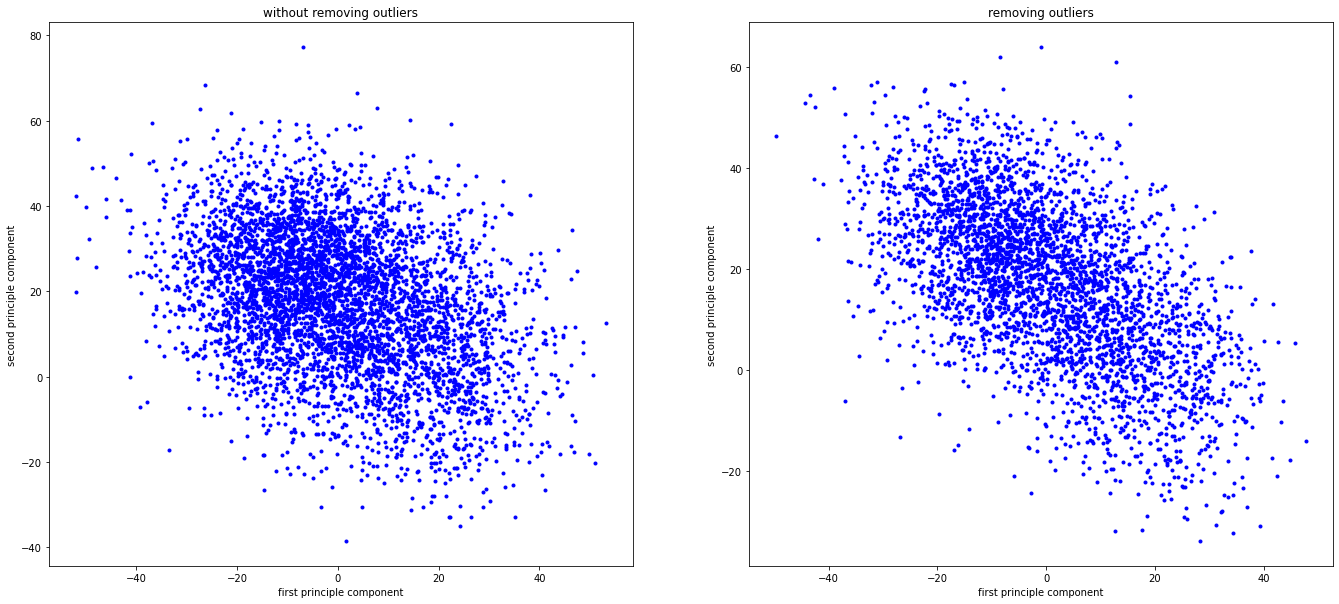

In [59]:
fig = plt.figure(figsize=(23,10))

ax1 = fig.add_subplot(121)
ax1.set_title('without removing outliers')
x = data_dim_reduced[0,:]
y = data_dim_reduced[1,:]
plt.xlabel('first principle component')
plt.ylabel('second principle component')
plt.scatter(x, y, c='b', marker='.')

ax2 = fig.add_subplot(122)
ax2.set_title('removing outliers')
x = data_dim_reduced_no_outlier[0,:]
y = data_dim_reduced_no_outlier[1,:]
plt.xlabel('first principle component')
plt.ylabel('second principle component')
plt.scatter(x, y, c='b', marker='.')

plt.show()

plot initially sorted data:

<function matplotlib.pyplot.show>

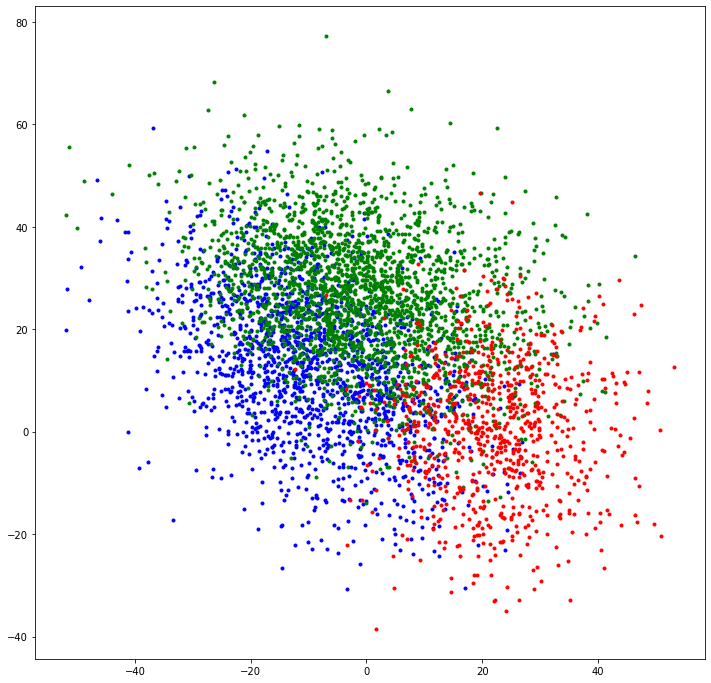

In [66]:
data_dim_reduced_t = np.transpose(data_dim_reduced)
cluster1 = data_dim_reduced_t[:data1.shape[0],:]
cluster2 = data_dim_reduced_t[cluster1.shape[0]:cluster1.shape[0]+data2.shape[0],:]
cluster3 = data_dim_reduced_t[cluster1.shape[0]+cluster2.shape[0]:,:]
fig = plt.figure(figsize=(12,12))
plt.scatter(np.transpose(cluster1)[0,:], np.transpose(cluster1)[1,:], c='b', marker='.')
plt.scatter(np.transpose(cluster2)[0,:], np.transpose(cluster2)[1,:], c='g', marker='.')
plt.scatter(np.transpose(cluster3)[0,:], np.transpose(cluster3)[1,:], c='r', marker='.')
plt.show

clustering by K-Means:

In [35]:
%run '/content/drive/MyDrive/Colab Notebooks/spike_sorting/k-means.ipynb'

In [9]:
print(data_dim_reduced_no_outlier.shape)

(2, 4590)


[ 0 96  1]
[1465   48    0]
[1902  644    0]
[4026  501    0]
[ 545 4158    0]
[2413    3 2288]
[   8 4742    0]
[4737   12    1]
[   0    0 4750]
[1175 3570    5]
[4673   74    3]
[   0   31 4719]
[  32 4713    5]
[ 709 4041    0]
[ 883 3807   60]
[4137   30  583]
[4021   59  670]
[ 412   49 4289]
[ 760   49 3941]
[ 872   49 3829]
[1545    6 3199]
[1484   67 3199]
[1546    5 3199]
[1546    5 3199]


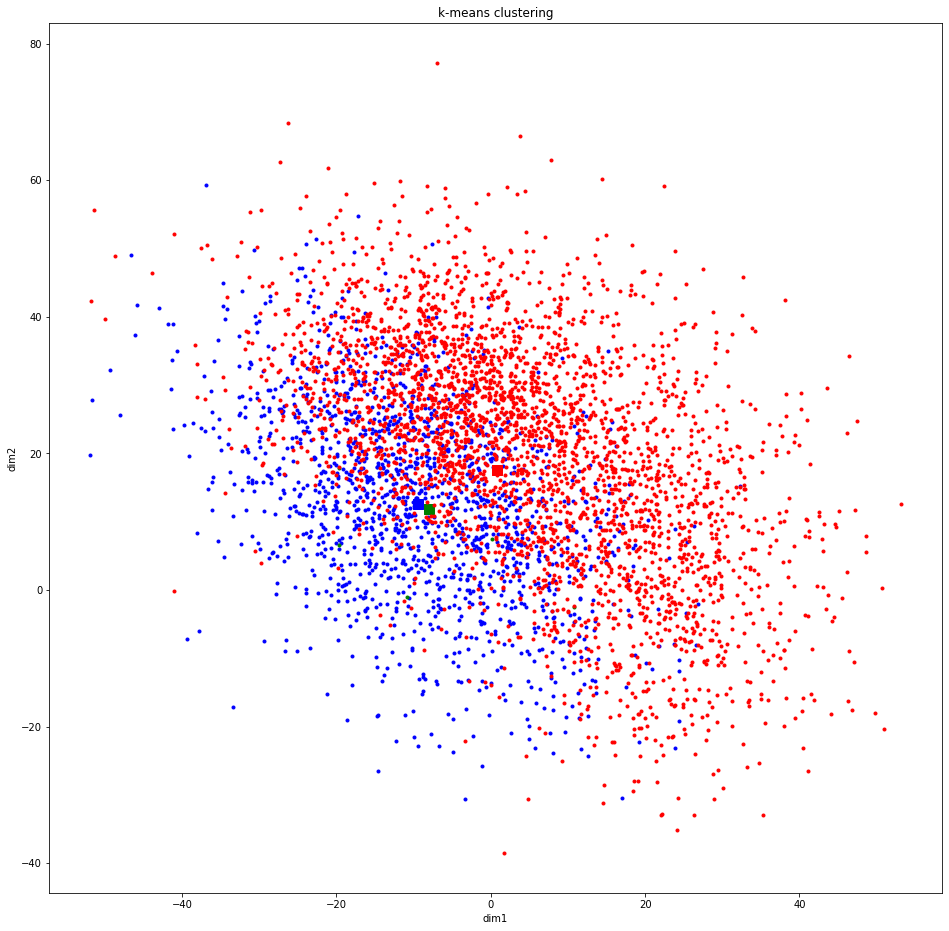

In [74]:
cluster_assignment, centroids = k_means(np.transpose(data_dim_reduced))
plot_clusters(np.transpose(data_dim_reduced), cluster_assignment, centroids)

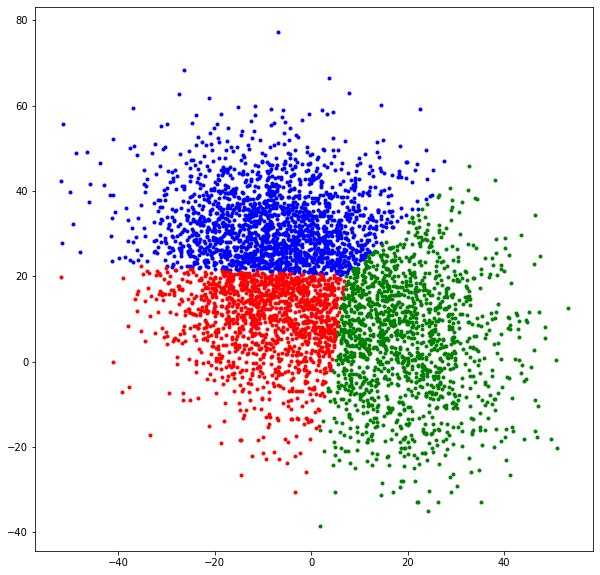

In [72]:
# using sklearn api
data_t = np.transpose(data_dim_reduced)
kmeans = KMeans(n_clusters=3, random_state=0).fit_predict(data_t)
fig = plt.figure(figsize=(10,10))
cluster1 = data_t[np.where(kmeans[:,]==0)]
cluster2 = data_t[np.where(kmeans[:,]==1)]
cluster3 = data_t[np.where(kmeans[:,]==2)]
plt.scatter(cluster1[:,0], cluster1[:,1], c='b',marker='.')
plt.scatter(cluster2[:,0], cluster2[:,1], c='g',marker='.')
plt.scatter(cluster3[:,0], cluster3[:,1], c='r',marker='.')

plot manually labelled clusters:

In [ ]:
data_dim_reduced = np.array(data_dim_reduced)

a, b, c = [], [], []
orig_a, orig_b, orig_c = [], [], []
for i in np.where(data_dim_reduced[1,:] > 200)[0]:
  x_value = data_dim_reduced[0][i]
  y_value = data_dim_reduced[1][i]
  above_line = 3 * x_value
  if x_value < -100:
    a.append([x_value, y_value])
    orig_a.append(data_concat[:,i])
  elif x_value > -100 and y_value > above_line:
    b.append([x_value, y_value])
    orig_b.append(data_concat[:,i])
  elif y_value < above_line:
    c.append([x_value, y_value])
    orig_c.append(data_concat[:,i])

cluster_a = np.array(a)
cluster_b = np.array(b)
cluster_c = np.array(c)

cluster_orig_a = np.array(orig_a)
cluster_orig_b = np.array(orig_b)
cluster_orig_c = np.array(orig_c)

IndexError: ignored

In [ ]:
fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(111)
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim((-1200,1200))
plt.ylim((-300,1800))

x_a = cluster_a[:,0]
y_a = cluster_a[:,1]

x_b = cluster_b[:,0]
y_b = cluster_b[:,1]

x_c = cluster_c[:,0]
y_c = cluster_c[:,1]

ax1.scatter(x_a, y_a, c = 'r', marker = '.')
ax1.scatter(x_b, y_b, c = 'b', marker = '.')
ax1.scatter(x_c, y_c, c = 'g', marker = '.')

plt.show()

fig2 = plt.figure(figsize=(12,12))
ax1 = fig2.add_subplot(311)
ax2 = fig2.add_subplot(312)
ax3 = fig2.add_subplot(313)
plt.xlabel('t')
plt.ylabel('haha')
plt.xlim((0,64))
plt.ylim((-200,200))

x = np.arange(64)

# cluster a
for i in range(cluster_orig_a.shape[0]):
  ax1.plot(x, cluster_orig_a[i], c = 'r', marker = '.')

# cluster b
for i in range(cluster_orig_b.shape[0]):
  ax2.plot(x, cluster_orig_b[i], c = 'b', marker = '.')

# cluster c
for i in range(cluster_orig_c.shape[0]):
  ax3.plot(x, cluster_orig_c[i], c = 'g', marker = '.')

plt.show()

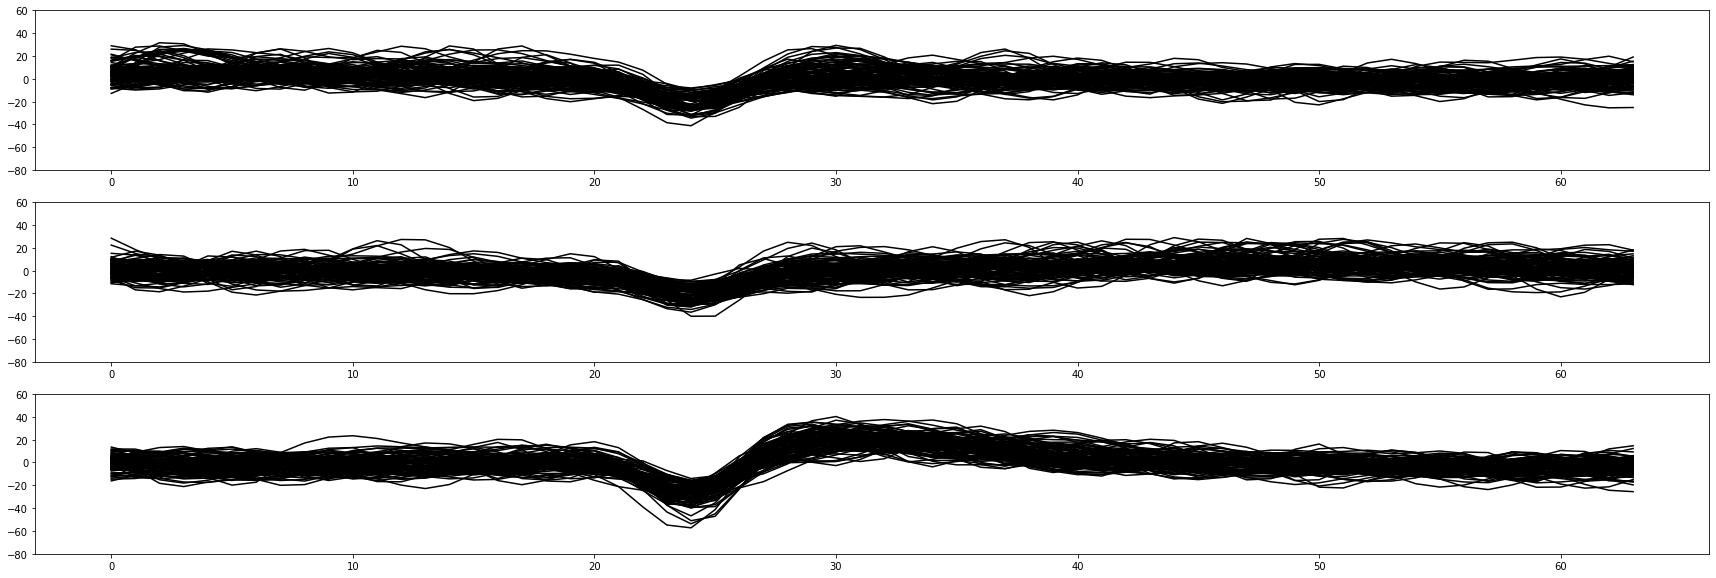

In [ ]:
fig3 = plt.figure(figsize=(30,10))

ax1 = fig3.add_subplot(311)
ax1.plot(np.transpose(data1)[0:64,0:100], c='k')
plt.ylim((-80,60))

ax2 = fig3.add_subplot(312)
ax2.plot(np.transpose(data2)[0:64,0:100], c='k')
plt.ylim((-80,60))

ax3 = fig3.add_subplot(313)
ax3.plot(np.transpose(data3)[0:64,0:100], c='k')
plt.ylim((-80,60))

plt.show()